# Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
sns.set_style("dark")

# Data

In [3]:
fraud_df = pd.read_csv("data/fraud_detection_dataset.csv")

# Data dictionary

- Available on **`README.md`**

# EDA

In [4]:
# checking the target distribution
fraud_df["isFraud"].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

As every fraud detection problem, we have a lot more information that there is not fraud than the data with fraud (1). 99% of the data is categorized as no fraud, so, if we try to guess where there is not fraud, we'll get right answer 99.88% of the time.

Let's change the name variables to snake case, just for preference

In [5]:
fraud_df.columns = ["step", "type", "amount", "name_orig", "old_balance_orig", "new_balance_orig", "name_dest", "old_balance_dest", "new_balance_dest", "is_fraud", "is_flagged_fraud"]

# change the order, last columns with the target
fraud_df = fraud_df[['step', 'type', 'amount', 'name_orig', 'old_balance_orig',
       'new_balance_orig', 'name_dest', 'old_balance_dest', 'new_balance_dest', 'is_flagged_fraud',
       'is_fraud']]

Let's separate our dataset in categorical variables and numerical ones. As we have just 11 variables, we can clearly see who is categorical and who is numerical:

- categorical: ["type", "name_orig", "name_dest", "is_flagged_fraud", "is_fraud"]
- numerical: ["step", "amount", "old_balance_orig", "new_balance_orig", "old_balance_dest", "new_balance_dest"]

In [6]:
# separating the dataset
fraud_categorical_df = fraud_df[["type", "name_orig", "name_dest", "is_flagged_fraud", "is_fraud"]]
fraud_numerical_df = fraud_df[["step", "amount", "old_balance_orig", "new_balance_orig", "old_balance_dest", "new_balance_dest", "is_fraud"]]  # will contain the target for a exploration step

Those dataframes:

In [7]:
fraud_categorical_df

,type,name_orig,name_dest,is_flagged_fraud,is_fraud
0,PAYMENT,C1231006815,M1979787155,0,0
1,PAYMENT,C1666544295,M2044282225,0,0
2,TRANSFER,C1305486145,C553264065,0,1
3,CASH_OUT,C840083671,C38997010,0,1
4,PAYMENT,C2048537720,M1230701703,0,0
...,...,...,...,...,...
6362615,CASH_OUT,C786484425,C776919290,0,1
6362616,TRANSFER,C1529008245,C1881841831,0,1
6362617,CASH_OUT,C1162922333,C1365125890,0,1
6362618,TRANSFER,C1685995037,C2080388513,0,1


In [8]:
fraud_numerical_df

,step,amount,old_balance_orig,new_balance_orig,old_balance_dest,new_balance_dest,is_fraud
0,1,9839.64,170136.00,160296.36,0.00,0.00,0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0
2,1,181.00,181.00,0.00,0.00,0.00,1
3,1,181.00,181.00,0.00,21182.00,0.00,1
4,1,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1


Here, we have a very unbalanced dataset, so, is very important that we can identify some relationships between fraud = 1 and all other variables. Let's investigate that

## EDA Categorical

I'll drop the names categories for now, those variables seems to be anonimized, and probably will not represent any information. I may go back to those variables later if needed.

In [9]:
fraud_categorical_dropped_df = fraud_categorical_df.drop(["name_orig", "name_dest"], axis=1)
fraud_categorical_dropped_df

,type,is_flagged_fraud,is_fraud
0,PAYMENT,0,0
1,PAYMENT,0,0
2,TRANSFER,0,1
3,CASH_OUT,0,1
4,PAYMENT,0,0
...,...,...,...
6362615,CASH_OUT,0,1
6362616,TRANSFER,0,1
6362617,CASH_OUT,0,1
6362618,TRANSFER,0,1


In [10]:
# fraud by type
fraud_by_type_df = fraud_categorical_dropped_df[["type", "is_fraud"]].value_counts().reset_index()
fraud_by_type_df.columns = ["type", "is_fraud", "qtt"]
fraud_by_type_df.sort_values(["type"])

,type,is_fraud,qtt
2,CASH_IN,0,1399284
0,CASH_OUT,0,2233384
5,CASH_OUT,1,4116
4,DEBIT,0,41432
1,PAYMENT,0,2151495
3,TRANSFER,0,528812
6,TRANSFER,1,4097


Here we can observe some points:

- **CASH_IN, DEBIT, PAYMENT: Every one of these categories are not fraud**
- CASH_OUT: this variable has a ratio of 99.25% not fraud
- TRANSFER: this variable has a ratio of 99.81% not fraud


In [11]:
# analysing the is_flagged_fraud variable with the 
fraud_categorical_dropped_df[["type", "is_flagged_fraud"]].value_counts()

type      is_flagged_fraud
CASH_OUT  0                   2237500
PAYMENT   0                   2151495
CASH_IN   0                   1399284
TRANSFER  0                    532893
DEBIT     0                     41432
TRANSFER  1                        16
dtype: int64

Look that the `is_flagged_fraud` variable = 1 happens just on `TRANSFER` class, like was told before. And also this happens just 16 times!

In [12]:
flagged_fraud_by_type_df = fraud_categorical_dropped_df[["is_flagged_fraud", "is_fraud"]].value_counts().reset_index()
flagged_fraud_by_type_df.columns = ["is_flagged_fraud", "is_fraud", "qtt"]
flagged_fraud_by_type_df.sort_values(["is_flagged_fraud"])

,is_flagged_fraud,is_fraud,qtt
0,0,0,6354407
1,0,1,8197
2,1,1,16


Here we have just 16 observations marked as **is_flagged_fraud**, this may not been significant. We'll probably drop this column for lack of variability, but for the baseline model we'll keep this variable.

## EDA Numerical

### Step

In [13]:
fraud_numerical_df

,step,amount,old_balance_orig,new_balance_orig,old_balance_dest,new_balance_dest,is_fraud
0,1,9839.64,170136.00,160296.36,0.00,0.00,0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0
2,1,181.00,181.00,0.00,0.00,0.00,1
3,1,181.00,181.00,0.00,21182.00,0.00,1
4,1,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1


Let's look at the step variable first, and count where are the large concentration of frauds across the hours.

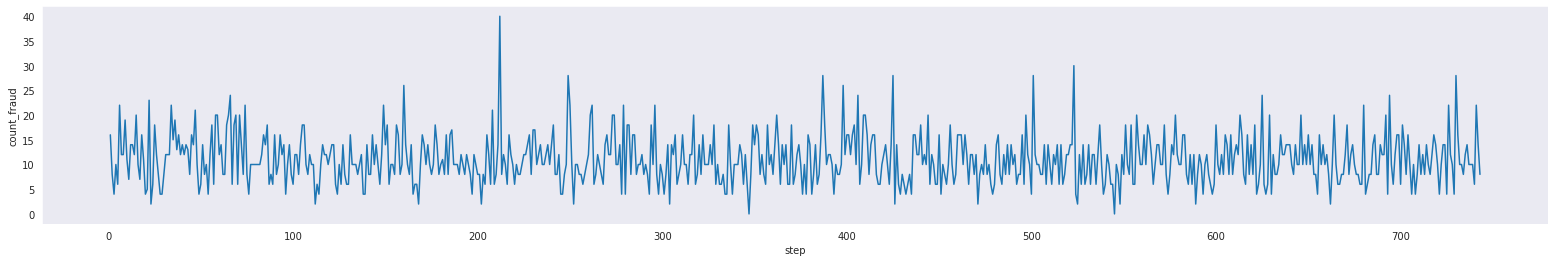

In [14]:
fraud_on_hours_df = fraud_numerical_df.groupby(["step"])["is_fraud"].agg(count_fraud = sum).reset_index()

# plot
fig_dims = (27, 4)
fig, ax = plt.subplots(figsize=fig_dims)
_ = sns.lineplot(x="step", y="count_fraud", data=fraud_on_hours_df, ax=ax)
plt.show()

In [15]:
fraud_on_hours_df.corr()

,step,count_fraud
step,1.000000,-0.036999
count_fraud,-0.036999,1.000000


In [34]:
fraud_on_hours_df[fraud_on_hours_df["step"] <= 24].corr()

,step,count_fraud
step,1.000000,-0.135076
count_fraud,-0.135076,1.000000


seeams to have more correlation between the day in it self than the fraud

In [16]:
fraud_on_hours_df.describe()

,step,count_fraud
count,743.000000,743.000000
mean,372.000000,11.053836
std,214.629914,4.998631
min,1.000000,0.000000
25%,186.500000,8.000000
50%,372.000000,10.000000
75%,557.500000,14.000000
max,743.000000,40.000000


Looking at this graph and the table, any hour has 0 fraud, at least one fraud happens. Normally we have a mean of 11 and a median of 10 frauds per 30 days.

In [17]:
fraud_on_hours_summary_df = fraud_numerical_df.groupby(["step"])["is_fraud"].agg(count_fraud = sum, mean_fraud = np.mean, median_fraud = np.median, count_values = np.size).reset_index()

In [35]:
fraud_on_hours_summary_df

,step,count_fraud,mean_fraud,median_fraud,count_values
0,1,16,0.005908,0.0,2708
1,2,8,0.007890,0.0,1014
2,3,4,0.007246,0.0,552
3,4,10,0.017699,0.0,565
4,5,6,0.009023,0.0,665
...,...,...,...,...,...
738,739,10,1.000000,1.0,10
739,740,6,1.000000,1.0,6
740,741,22,1.000000,1.0,22
741,742,14,1.000000,1.0,14


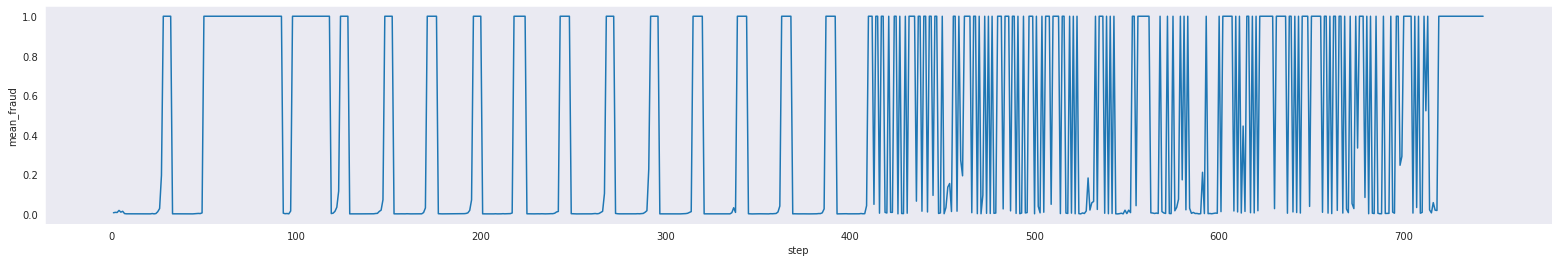

In [18]:
fig_dims = (27, 4)
fig, ax = plt.subplots(figsize=fig_dims)
_ = sns.lineplot(x="step", y="mean_fraud", data=fraud_on_hours_summary_df, ax=ax)
plt.show()

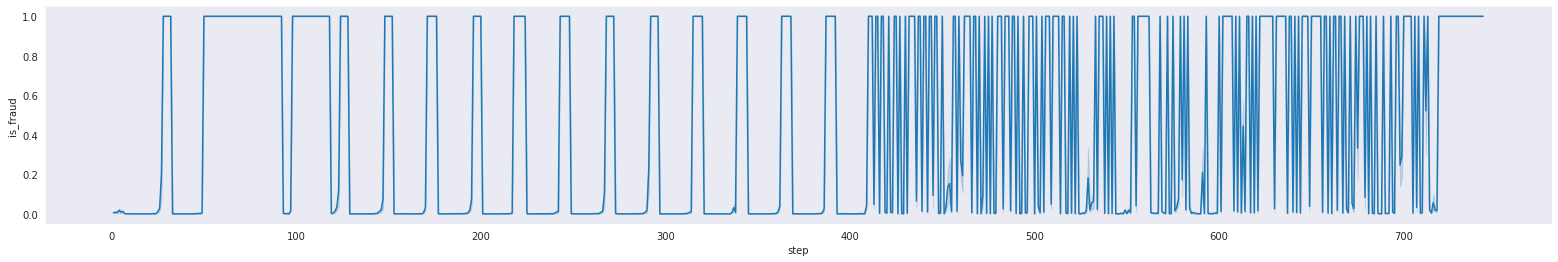

In [19]:
fig_dims = (27, 4)
fig, ax = plt.subplots(figsize=fig_dims)
_ = sns.lineplot(x="step", y="is_fraud", data=fraud_numerical_df, ax=ax)
plt.show()

Seems that we have a very different distribution of frauds after the 400 hrs of those 30 days. Let's check the mean of frauds before and after 400.

In [37]:
mean_before_400 = fraud_numerical_df[fraud_numerical_df.step <= 400]["is_fraud"].mean()
mean_after_400 = fraud_numerical_df[fraud_numerical_df.step > 400]["is_fraud"].mean()
print(f"Mean before 400hr: {mean_before_400}\nMean after 400hr: {mean_after_400}")

Mean before 400hr: 0.0007736265407298736
Mean after 400hr: 0.006490731249674247


In [38]:
15*24

360

In [21]:
value_counts_b_400 = fraud_numerical_df[fraud_numerical_df.step <= 400]["is_fraud"].value_counts().reset_index()
value_counts_a_400 = fraud_numerical_df[fraud_numerical_df.step > 400]["is_fraud"].value_counts().reset_index()
print(f"Mean before 400hr: {display(value_counts_b_400)}\nMean after 400hr: {display(value_counts_a_400)}")

,index,is_fraud
0,0,5782553
1,1,4477


,index,is_fraud
0,0,571854
1,1,3736


Mean before 400hr: None
Mean after 400hr: None


Here we're seeing that besides the fraud rate been the same before and after 400, the quantity of register, and consequently the number of non fraud, is larger on the first 400hrs of the day. **Is this pattern happens in reality or just on this simulation data?**

In [36]:
3736/571854


0.0065331360801883

### Amount

In [39]:
b_400 = fraud_numerical_df[fraud_numerical_df.step <= 400].groupby(["is_fraud"])["amount"].agg([np.mean]).reset_index()
a_400 = fraud_numerical_df[fraud_numerical_df.step > 400].groupby(["is_fraud"])["amount"].agg([np.mean]).reset_index()

b_400

,is_fraud,mean
0,0,1.804040e+05
1,1,1.403494e+06


In [40]:
a_400

,is_fraud,mean
0,0,1.558804e+05
1,1,1.545228e+06


Let's see the mean of those transactions by `step`, by `step` and `is_fraud` and by `is_fraud`

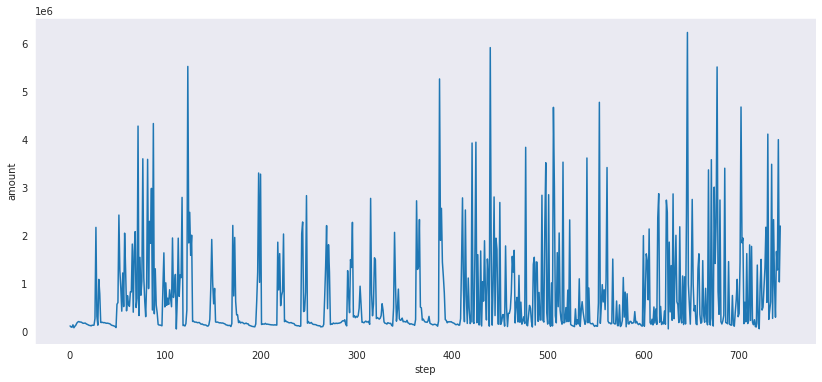

In [23]:
mean_amount_by_step = fraud_numerical_df.groupby(["step"])["amount"].mean().reset_index()

# plot
fig_dims = (14, 6)
fig, ax = plt.subplots(figsize=fig_dims)

_ = sns.lineplot(x="step", y="amount", data=mean_amount_by_step, ax=ax)
plt.show()

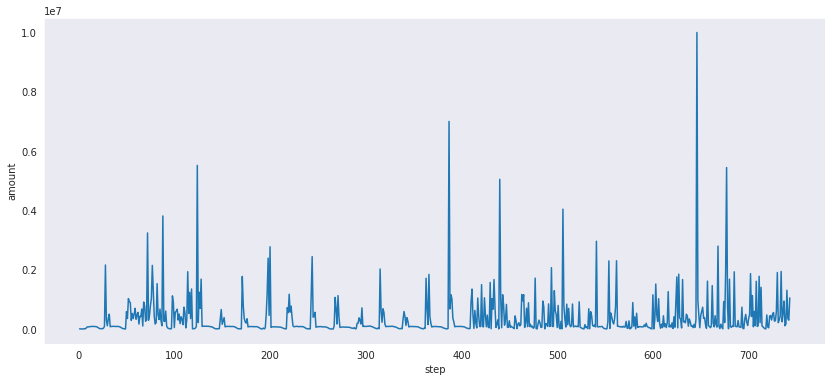

In [24]:
median_amount_by_step = fraud_numerical_df.groupby(["step"])["amount"].median().reset_index()

# plot
fig_dims = (14, 6)
fig, ax = plt.subplots(figsize=fig_dims)

_ = sns.lineplot(x="step", y="amount", data=median_amount_by_step, ax=ax)
plt.show()

In [54]:
pd.concat([median_amount_by_step, fraud_on_hours_summary_df.drop(["step"], axis=1)], axis=1).corr()

,step,amount,count_fraud,mean_fraud,median_fraud,count_values
step,1.000000,0.082713,-0.036999,0.154386,0.146488,-0.383755
amount,0.082713,1.000000,0.083042,0.474368,0.473815,-0.253254
count_fraud,-0.036999,0.083042,1.000000,0.048786,0.045536,0.047061
mean_fraud,0.154386,0.474368,0.048786,1.000000,0.996995,-0.572958
median_fraud,0.146488,0.473815,0.045536,0.996995,1.000000,-0.557470
count_values,-0.383755,-0.253254,0.047061,-0.572958,-0.557470,1.000000


In [51]:
fraud_on_hours_summary_df

,step,count_fraud,mean_fraud,median_fraud,count_values
0,1,16,0.005908,0.0,2708
1,2,8,0.007890,0.0,1014
2,3,4,0.007246,0.0,552
3,4,10,0.017699,0.0,565
4,5,6,0.009023,0.0,665
...,...,...,...,...,...
738,739,10,1.000000,1.0,10
739,740,6,1.000000,1.0,6
740,741,22,1.000000,1.0,22
741,742,14,1.000000,1.0,14


At the end of the numerical eda, is a good idea to look at the correlation between some variables related to the mean or median of fraud by hour. This because the amount of the transaction appear to be correlated to when happens fraud or not.

The amount variable is the module of the difference between new_balance_orig - old_balance_orig. **One variable that is possible a good idea to create** is the difference between the destination of the money too (old_balance_dest and new_balance_dest).

In [25]:
fraud_df

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_flagged_fraud,is_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0,1


We'll now see some of those before plots by our categorical variable (`type`). This may be important to see if there is some pattern.

In [26]:
fraud_describe_by_type_df = fraud_df.groupby(["type", "step"])["is_fraud"].agg(count_fraud = sum, mean_fraud = np.mean, median_fraud = np.median, count_values = np.size).reset_index()
fraud_describe_by_type_df

,type,step,count_fraud,mean_fraud,median_fraud,count_values
0,CASH_IN,1,0,0.0,0.0,527
1,CASH_IN,2,0,0.0,0.0,203
2,CASH_IN,3,0,0.0,0.0,124
3,CASH_IN,4,0,0.0,0.0,136
4,CASH_IN,5,0,0.0,0.0,131
...,...,...,...,...,...,...
2724,TRANSFER,739,5,1.0,1.0,5
2725,TRANSFER,740,3,1.0,1.0,3
2726,TRANSFER,741,11,1.0,1.0,11
2727,TRANSFER,742,7,1.0,1.0,7


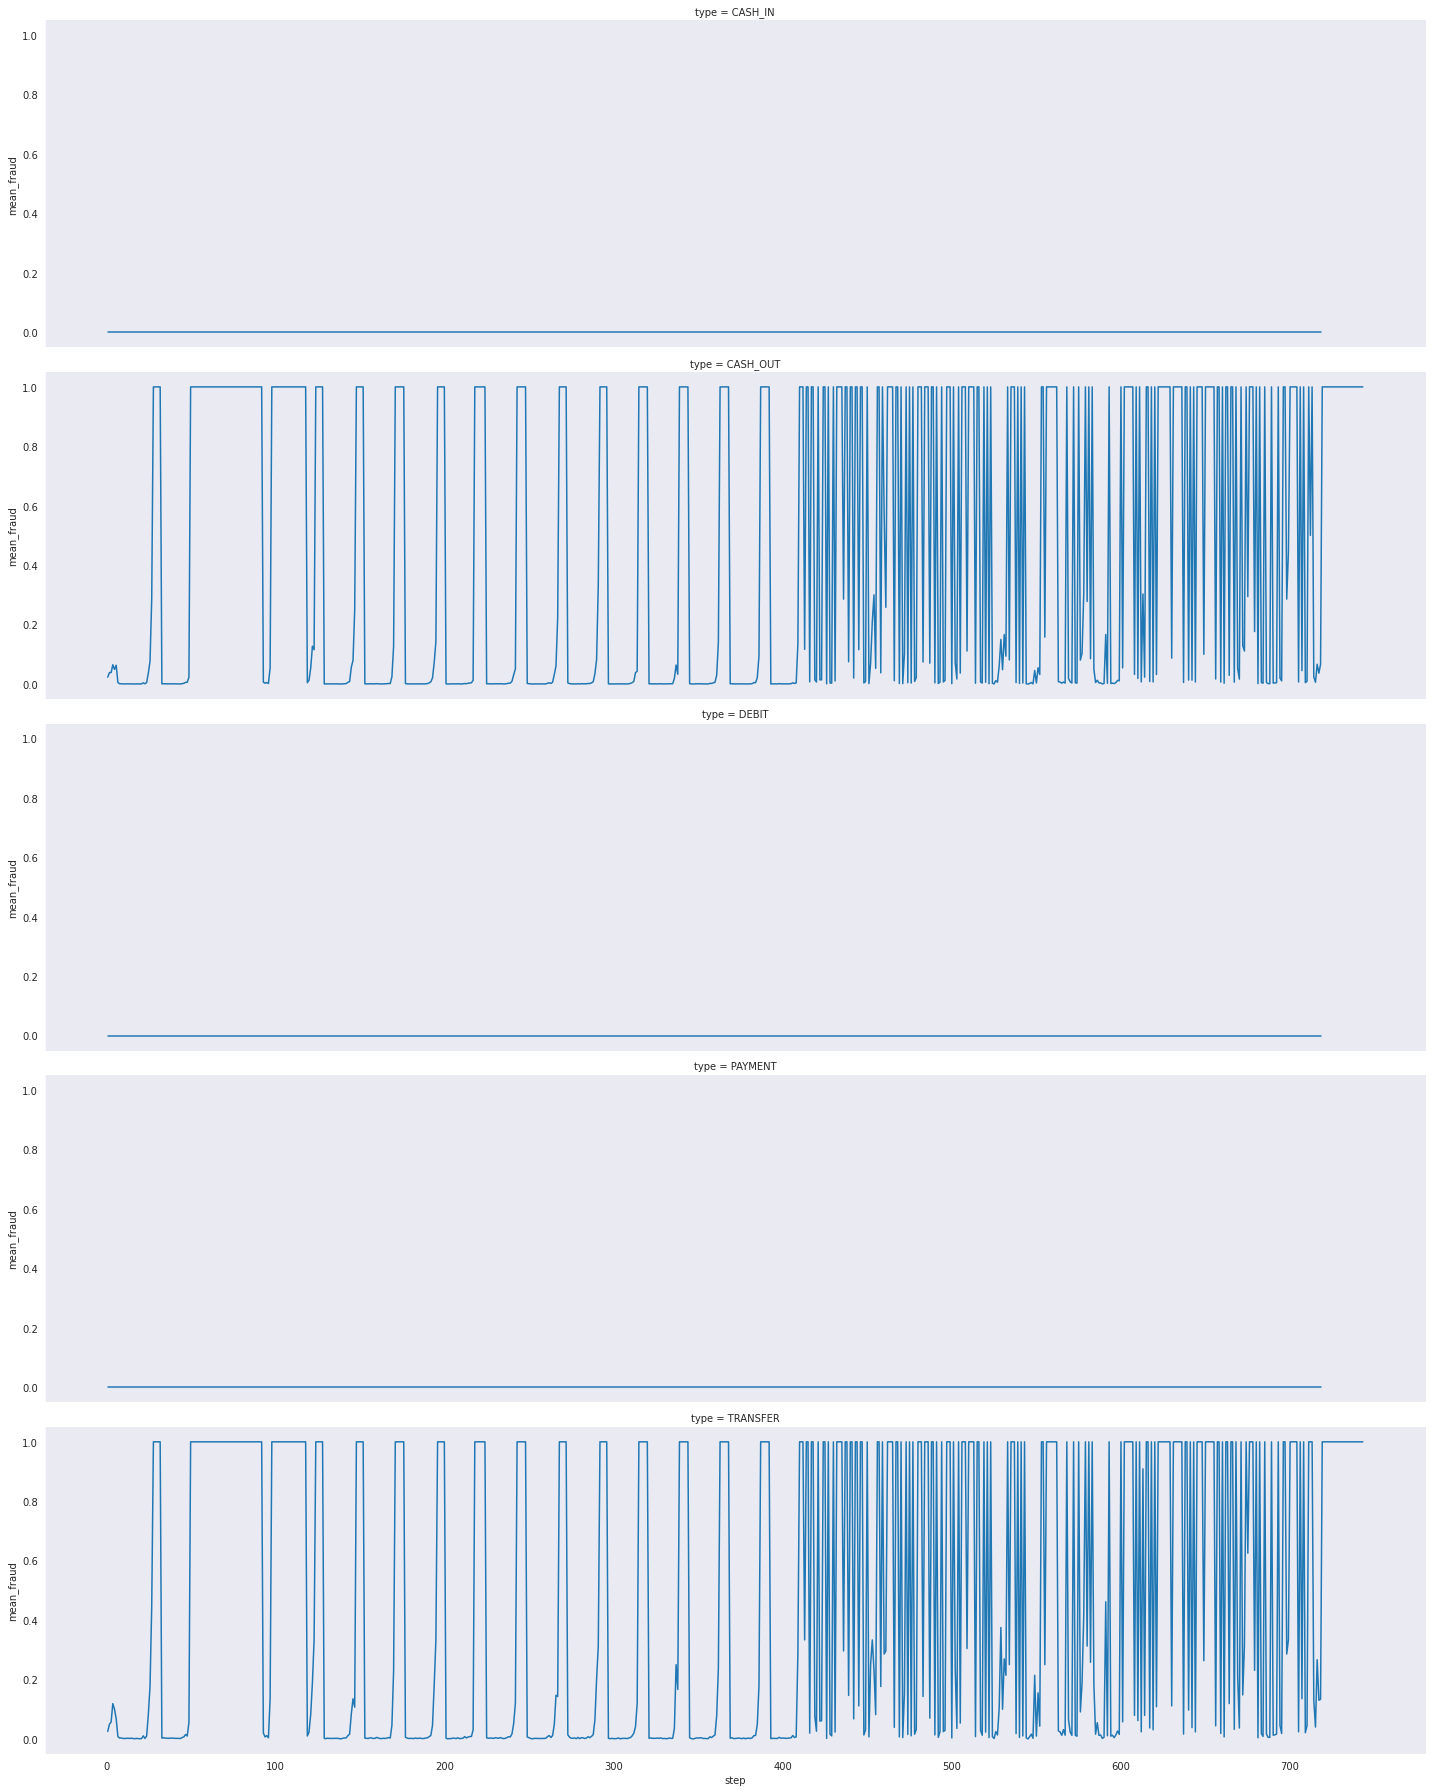

In [27]:
g = sns.FacetGrid(data=fraud_describe_by_type_df, row="type", height=5, aspect=4)
g.map(sns.lineplot, "step", "mean_fraud")
plt.show()

We need the correlation between transfer and cash_out mean of fraud by hour.

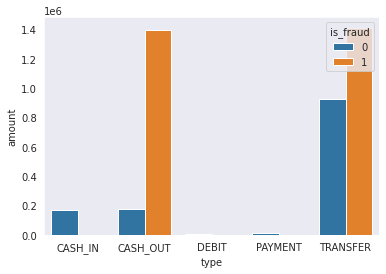

In [28]:
# before that, I'll check another thing

before_400 = fraud_df[fraud_df.step <= 400]
after_400 = fraud_df[fraud_df.step > 400]

mean_amount_b_400 = before_400.groupby(["type", "is_fraud"])["amount"].mean().reset_index()
mean_amount_a_400 = after_400.groupby(["type", "is_fraud"])["amount"].mean().reset_index()

_ = sns.barplot(x="type", y="amount", hue="is_fraud", data=mean_amount_b_400)
plt.show()


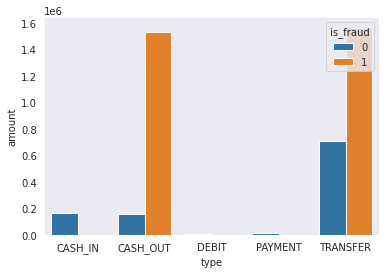

In [29]:
_ = sns.barplot(x="type", y="amount", hue="is_fraud", data=mean_amount_a_400)
plt.show()


Seems that the mean of amount variable on fraud = 0 is higher on the less than 400hrs. The other way also happens for fraud = 1 on the mean of amount after than 400hrs.

Based on this initial EDA, I'll create a pipeline and a baseline model to start the development of the API. 

In [30]:
fraud_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   type              object 
 2   amount            float64
 3   name_orig         object 
 4   old_balance_orig  float64
 5   new_balance_orig  float64
 6   name_dest         object 
 7   old_balance_dest  float64
 8   new_balance_dest  float64
 9   is_flagged_fraud  int64  
 10  is_fraud          int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


No missings

### Hypothesis: is the numbers of zeros on the origin after the transaction, related to fraud or not?

In [31]:
fraud_df.isFlaggedFraud.value_counts()

AttributeError: 'DataFrame' object has no attribute 'isFlaggedFraud'

In [ ]:
fraud_df[fraud_df["isFlaggedFraud"] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [ ]:
fraud_df[(fraud_df["amount"] > 200000) & (fraud_df["type"] == "TRANSFER")].sort_values(["nameOrig"])

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2825292,226,TRANSFER,3228390.11,C1000005353,24996.0,0.0,C292963054,878327.64,4106717.75,0,0
5502195,380,TRANSFER,3229333.12,C1000005749,0.0,0.0,C1247252665,9987425.74,13216758.86,0,0
4275204,307,TRANSFER,673726.47,C1000008236,307.0,0.0,C107425672,0.00,673726.47,0,0
1550135,154,TRANSFER,235163.72,C1000009606,0.0,0.0,C1311531655,779432.65,1014596.37,0,0
2996008,232,TRANSFER,420906.13,C1000024959,0.0,0.0,C251954641,505697.03,926603.16,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4622286,329,TRANSFER,2133917.74,C99998531,104479.0,0.0,C52928032,480561.48,2614479.21,0,0
965207,44,TRANSFER,231011.32,C999985598,0.0,0.0,C1214649208,841177.65,1072188.97,0,0
2405639,202,TRANSFER,675316.04,C999986955,32091.0,0.0,C1455999020,0.00,675316.04,0,0
545982,21,TRANSFER,377965.32,C999988902,24808.0,0.0,C1482476379,0.00,377965.32,0,0


In [ ]:
fraud_df["nameOrig"].value_counts()

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64